## K Nearest Neighbors



<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png" alt="KNN-Example" style="width: 320px;" align="right"/>The k-nearest neighbors algorithm ([KNN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)) is a non-parametric method.

KNN relies on the observation that (in an appropriate embedding space) similar images exist in proximity. A new test image is classified by simply looking at nearby train images and aggregating the evidence.

<img src="https://miro.medium.com/max/700/1*syyml8q8s1Yt-iEea5m1Ag.png" alt="CIFAR-10-Samples" width="50%" align="left"/>

The number of neighbors used for prediction may lead to varying outcomes. For example, the green circle (left image) may be classified either as a red triangle based on 3-nearest-neighbors or as a blue square based on the 5-nearest-neighbors.

In this exercise, we will apply KNN to classify the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset (see left image). CIFAR-10 consists of 32x32 images from 10 classes. The train set consists of 50k images and the test set consists of 10k images. The following is are sample images from each class:


### Function to load CIFAR-10.

**You do not need to fully understand this**. (Might help for later homeworks though)

`torchvision.datasets.CIFAR10` is a `Dataset` object, where `data[i]` gives you a single sample.
`torch.utils.data.DataLoader` wraps a dataset, and makes it fast (`num_workers`) as well as providing other useful features such as shuffling and batching.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

def fetch_dataloader(transform=None, batch_size=-1, is_train=True):
    """
    Loads data from disk and returns a data_loader.
    A DataLoader is similar to a list of (image, label) tuples.
    You do not need to fully understand this code to do this assignment, we're happy to explain though.
    """
    data = torchvision.datasets.CIFAR10(root='./data', train=is_train, download=True, transform=transform)
    batch = len(data) if batch_size is -1 else batch_size
    loader = torch.utils.data.DataLoader(data, batch_size=batch, shuffle=True, num_workers=4)

    return loader

### Fetch and preprocess data.

**You do not need to fully understand this.** What the code below does is load the training data into `x_train` of the size $N \times 3 \times 32 \times 32$ with $N$ labels `y_train` in $0 \ldots 9$.

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# -1 Batch size will give the entire dataset as one batch.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_batch_size = 5000
loader_train = fetch_dataloader(transform, batch_size=train_batch_size, is_train=True)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Implementing KNN

Implement the `train` and `predict` functions here.

### Hints:

It is a good idea to represent the images, which are (3, 32, 32) tensors,  
as vectors of size 32768 = (3 * 32 * 32).

`torch.reshape` will be helpful in doing this.

In [ ]:
class KNearestNeighborClassifier:
    def __init__(self, k):
        self.k = k

    def train(self, x_train, y_train):
        """
        Args:
            x_train: (n, 3, 32, 32) tensor of training images
            y_train: (n) long tensor of training labels

        Implement this function to "train" your knn classifier.

        Hint: no computation is involved
        """
        self.x, self.y = x_train.view(-1, 3*32*32), y_train

    def predict(self, image):
        """
        Args:
            image: (3, 32, 32) tensor

        Returns:
            (int) class label

        Implement this function.

        Compute distances between a test image and all train samples.
        Predict the label by voting on K nearest train samples.

        torch.topk might be useful.
        """
        distance = (self.x - image.reshape(-1)).norm(dim=1)
        k_norms, indices = distance.topk(self.k, dim=0, largest=False)
        return torch.tensor([self.y[i] for i in indices]).mode()[0].item()


### Evaluate on test data.

Play around with the hyperparameter `k` to see how it affects your accuracy.

In [ ]:
def get_predictions(model, x):
    """
    No need to change this
    """
    return torch.FloatTensor([model.predict(x_i) for x_i in x])


def compute_accuracy(y_pred, y_test):
    """
    Args:
        model: a trained KNN model
        x_pred: (10000) tensor of test predictions
        y_test: (10000) tensor of test labels

    Returns:
        (python float) representing the accuracy across the test set.

    Compute predictions on all test samples and report accuracy.
    """
    return (torch.sum(y_pred == y_test).item()/y_pred.shape[0]) * 100

test_batch_size = 500
loader_test = fetch_dataloader(transform, batch_size=test_batch_size, is_train=False)

import numpy as np
acc = np.zeros(50)

for i in range(50):
    # Train
    K = i + 1
    x_train, y_train = iter(loader_train).next()
    model = KNearestNeighborClassifier(k=K)
    model.train(x_train, y_train)
    # Evaluate
    x_test, y_test = iter(loader_test).next()
    y_pred = get_predictions(model, x_test)
    accuracy = compute_accuracy(y_pred, y_test)
    acc[i] = accuracy
    print(f'K: {K} Acc: {accuracy}')


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


K: 1 Acc: 26.0
K: 2 Acc: 25.0
K: 3 Acc: 23.799999999999997
K: 4 Acc: 30.599999999999998
K: 5 Acc: 26.400000000000002
K: 6 Acc: 25.0
K: 7 Acc: 29.4
K: 8 Acc: 23.599999999999998
K: 9 Acc: 29.599999999999998
K: 10 Acc: 23.0
K: 11 Acc: 28.199999999999996
K: 12 Acc: 30.599999999999998
K: 13 Acc: 27.200000000000003
K: 14 Acc: 25.2
K: 15 Acc: 26.400000000000002
K: 16 Acc: 25.2
K: 17 Acc: 31.4
K: 18 Acc: 26.0
K: 19 Acc: 30.8
K: 20 Acc: 28.199999999999996
K: 21 Acc: 26.400000000000002
K: 22 Acc: 28.199999999999996
K: 23 Acc: 28.000000000000004
K: 24 Acc: 32.800000000000004
K: 25 Acc: 25.8
K: 26 Acc: 31.0
K: 27 Acc: 29.4
K: 28 Acc: 26.8
K: 29 Acc: 28.999999999999996
K: 30 Acc: 24.6
K: 31 Acc: 24.2
K: 32 Acc: 27.200000000000003
K: 33 Acc: 24.0
K: 34 Acc: 27.800000000000004
K: 35 Acc: 27.6
K: 36 Acc: 24.0
K: 37 Acc: 28.000000000000004
K: 38 Acc: 28.599999999999998
K: 39 Acc: 25.0
K: 40 Acc: 23.200000000000003
K: 41 Acc: 21.0
K: 42 Acc: 25.8
K: 43 Acc: 27.6
K: 44 Acc: 24.6
K: 45 Acc: 28.4
K: 46 Acc

### Plot K with Accuracy

Trained on 5000 images with K: [1, 50]
Testing on 500 images


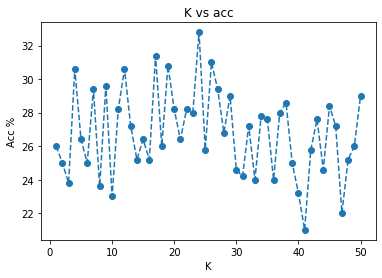

Highest Accuracy: 32.80% with K: 23


In [ ]:
import matplotlib.pyplot as plt

print(f'Trained on {train_batch_size} images with K: [1, {50}]')
print(f'Testing on {test_batch_size} images')

plt.title('K vs acc')
plt.gca().set_xlabel('K')
plt.gca().set_ylabel('Acc %')
plt.plot(range(1, 50 + 1), acc, 'o--')
plt.show()

print(f'Highest Accuracy: {acc.max():.2f}% with K: {acc.argmax()}')

In [ ]:
acc = np.zeros(5)
K = 0
for i in range(5):
    # Train
    K = K + 100
    x_train, y_train = iter(loader_train).next()
    model = KNearestNeighborClassifier(k=K)
    model.train(x_train, y_train)
    # Evaluate
    x_test, y_test = iter(loader_test).next()
    y_pred = get_predictions(model, x_test)
    accuracy = compute_accuracy(y_pred, y_test)
    acc[i] = accuracy
    print(f'K: {K} Acc: {accuracy}')


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


K: 100 Acc: 27.6
K: 200 Acc: 24.6
K: 300 Acc: 26.8
K: 400 Acc: 22.8
K: 500 Acc: 23.799999999999997


Trained on 5000 images with K: [100, 200, 300, 400, 500]
Testing on 500 images


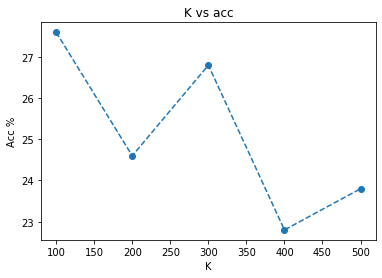

Highest Accuracy: 27.60% with K: 100


In [ ]:
print(f'Trained on {train_batch_size} images with K: [100, 200, 300, 400, 500]')
print(f'Testing on {test_batch_size} images')

plt.title('K vs acc')
plt.gca().set_xlabel('K')
plt.gca().set_ylabel('Acc %')
plt.plot(range(100, 500 + 1, 100), acc, 'o--')
plt.show()

print(f'Highest Accuracy: {acc.max():.2f}% with K: {acc.argmax() * 100 + 100}')

### References
KNN visual example is modeled after the [KNN Wikipedia article](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

CIFAR10 data montage is borrowed from the CIFAR10 [homepage](https://www.cs.toronto.edu/~kriz/cifar.html).

Dataloader and visualizer borrowed from the [PyTorch Tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).